In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score,classification_report,roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import OrderedDict

np.random.seed(42)

## Read Data

In [5]:
df = pd.read_csv("V2_ENG_interview_dataset.csv", dtype=str, infer_datetime_format=True)

Drop bad rows and cols

In [6]:
df = df.loc[df["Unnamed: 10"].isna()]
df = df.dropna(axis=1)

Test if are bad Lines


In [7]:
pd.to_numeric(df["Amount"], errors="raise");

Correct Data types

In [8]:
types = {"Year-Month":int, "Agency Number":int,	"Agency Name":str, "Cardholder Last Name":str, "Cardholder First Initial":str, "Amount":float, "Vendor":str, "Transaction Date":str, "Posted Date":str,	"Merchant Category Code (MCC)":str}

In [9]:
df = df.astype(types)
df["Posted Date"] = pd.to_datetime(df["Posted Date"])
df["Transaction Date"] = pd.to_datetime(df["Transaction Date"])

Format Data

In [10]:
df["Days Delay"] = (df["Posted Date"] - df["Transaction Date"]).dt.days
df.insert(1, "Year", df["Year-Month"]//100)
df.insert(2, "Month", df["Year-Month"]%100)
df.drop("Year-Month", axis=1, inplace=True)
df.head(5)

,Year,Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC),Days Delay
0,2013,7,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,890.00,NACAS,2013-07-30,2013-07-31,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,1
1,2013,7,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,368.96,SHERATON HOTEL,2013-07-30,2013-07-31,SHERATON,1
2,2013,7,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,165.82,SEARS.COM 9300,2013-07-29,2013-07-31,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,2
3,2013,7,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,96.39,WAL-MART #0137,2013-07-30,2013-07-31,"GROCERY STORES,AND SUPERMARKETS",1
4,2013,7,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,125.96,STAPLES DIRECT,2013-07-30,2013-07-31,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT...",1


In [11]:
df_op = df.loc[df["Amount"] > 0]

In [12]:
pd.DataFrame(df_op['Merchant Category Code (MCC)'].value_counts())

,Merchant Category Code (MCC)
"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRITING PAPER",23998
BOOK STORES,21392
INDUSTRIAL SUPPLIES NOT ELSEWHERE CLASSIFIED,21026
DENTAL/LABORATORY/MEDICAL/OPHTHALMIC HOSP EQIP AND SUP.,19805
"GROCERY STORES,AND SUPERMARKETS",16688
...,...
TAJ HOTELS INT'L,1
VIRGIN ATLANTIC,1
SWISS INTERNATIONAL AIR LINES,1
AMBULANCE SERVICES,1


In [13]:
pd.DataFrame(df_op['Cardholder Last Name'].value_counts())

,Cardholder Last Name
JOURNEY HOUSE TRAVEL INC,9650
UNIVERSITY AMERICAN,6997
JOURNEY HOUSE TRAVEL,4511
Heusel,4050
Hines,3322
...,...
KRAMER,1
Bonds,1
McMaine,1
Cabiran,1


In [14]:
pd.DataFrame(df_op.loc[df_op['Cardholder Last Name'] == 'UNIVERSITY AMERICAN']['Cardholder First Initial'].value_counts())

,Cardholder First Initial
G,6997


In [15]:
df_op.head(5)

,Year,Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC),Days Delay
0,2013,7,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,890.00,NACAS,2013-07-30,2013-07-31,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,1
1,2013,7,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,368.96,SHERATON HOTEL,2013-07-30,2013-07-31,SHERATON,1
2,2013,7,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,165.82,SEARS.COM 9300,2013-07-29,2013-07-31,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,2
3,2013,7,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,96.39,WAL-MART #0137,2013-07-30,2013-07-31,"GROCERY STORES,AND SUPERMARKETS",1
4,2013,7,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,125.96,STAPLES DIRECT,2013-07-30,2013-07-31,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT...",1


##  XGBoost

In [46]:
person = 'UNIVERSITY AMERICAN'

cat_vars = ['Merchant Category Code (MCC)']
numeric_vars = ['Amount']
categories = ['Cardholder Last Name'] + numeric_vars + cat_vars

params = {
    'num_rounds':        10,
    'max_depth':         8,
    'max_leaves':        2**8,
    'alpha':             0.9,
    'eta':               0.1,
    'gamma':             0.1,
    'learning_rate':     0.1,
    'subsample':         1,
    'reg_lambda':        1,
    'scale_pos_weight':  2,
    'tree_method':       'gpu_hist',
    'n_gpus':            1,
    'objective':         'binary:logistic',
    'verbose':           True
}

In [48]:
df_cp = df_op[categories].copy()
df_cp["labels"] = (df_cp['Cardholder Last Name'] == person)

In [51]:
cat_data = pd.get_dummies(df_cp[cat_vars])
numeric_data = df_cp[numeric_vars].copy()
numeric_cat_data = pd.concat([numeric_data, cat_data], axis=1)
numeric_cat_label_data = pd.concat([numeric_cat_data, df_cp["labels"].copy()], axis=1)

In [59]:
df_true_transations = numeric_cat_label_data.loc[numeric_cat_label_data['labels'] == True].copy()
df_false_transations = numeric_cat_label_data.loc[numeric_cat_label_data['labels'] == False].sample(n=df_true_transations.shape[0]).copy()
df_transations = pd.concat([df_true_transations, df_false_transations], axis=0)
labels = df_transations['labels']
df_transations.drop('labels', axis=1, inplace=True)

In [61]:
x_train, x_test, y_train, y_test = train_test_split(df_transations, labels, test_size=.25, random_state=42)
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
evals = [(dtest, 'test'), (dtrain, 'train')]

In [62]:
model = xgb.train(params, dtrain, params['num_rounds'], evals=evals)

[14:37:48] WARNING: ../src/learner.cc:767: 
Parameters: { "n_gpus", "num_rounds", "verbose" } are not used.

[0]	test-logloss:0.61199	train-logloss:0.61164
[1]	test-logloss:0.54563	train-logloss:0.54494
[2]	test-logloss:0.49046	train-logloss:0.48947
[3]	test-logloss:0.44407	train-logloss:0.44282
[4]	test-logloss:0.40489	train-logloss:0.40345
[5]	test-logloss:0.37128	train-logloss:0.36958
[6]	test-logloss:0.34212	train-logloss:0.34039
[7]	test-logloss:0.31704	train-logloss:0.31509
[8]	test-logloss:0.29544	train-logloss:0.29327
[9]	test-logloss:0.27643	train-logloss:0.27397


In [63]:
threshold = .5
true_labels = y_test.astype(int)

In [64]:
preds = model.predict(dtest)
pred_labels = (preds > threshold).astype(int)

In [65]:
auc = roc_auc_score(true_labels, preds)
print(auc)

0.9791621333573801


In [66]:
print ('Accuracy:', accuracy_score(true_labels, pred_labels))

Accuracy: 0.9611317519291226


Confusion Matrix :


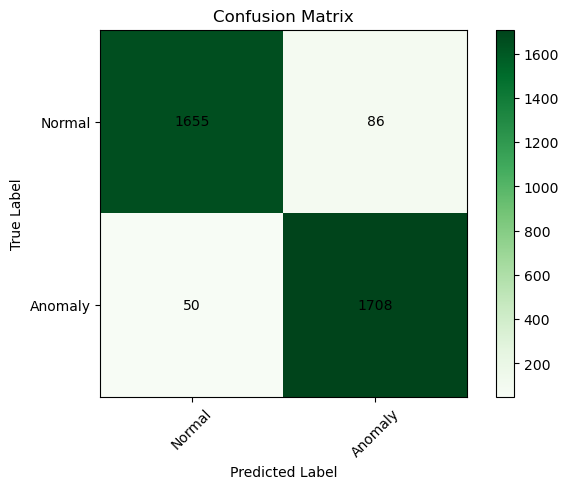

In [67]:
results = confusion_matrix(true_labels, pred_labels) 

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


plot_confusion_matrix(results, ['Normal','Anomaly'])

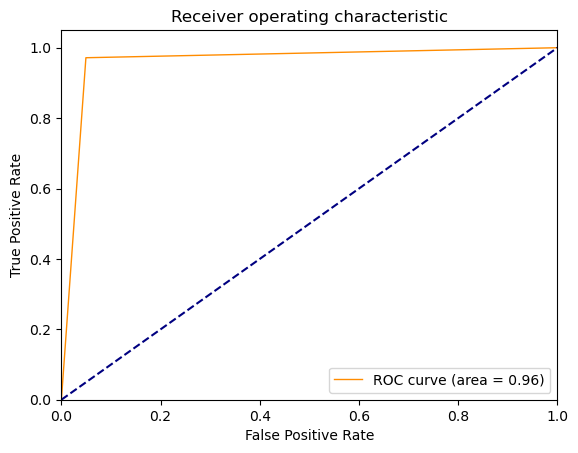

In [68]:
fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, pred_labels)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

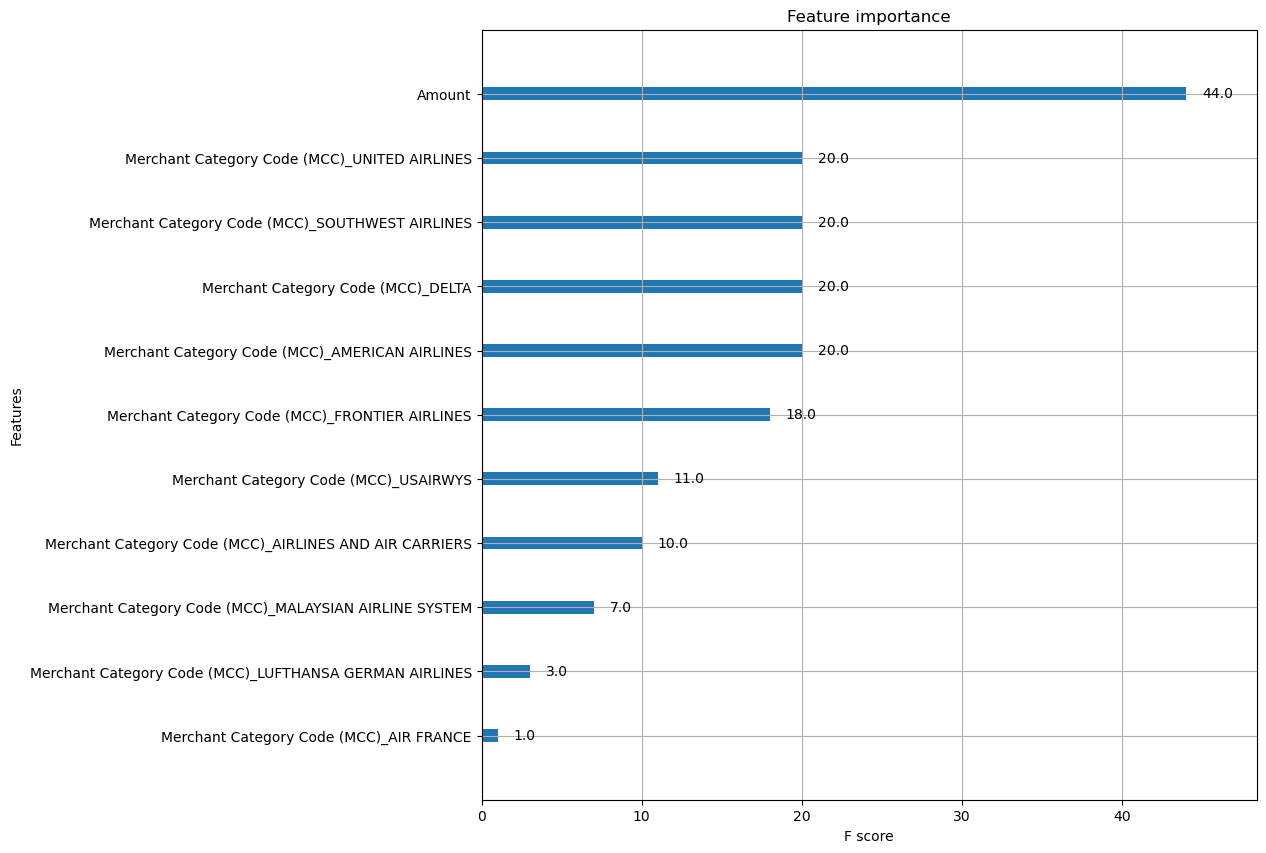

In [69]:
ax = xgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(10, 10)

In [70]:
df_true_transations = numeric_cat_label_data.loc[numeric_cat_label_data['labels'] == True].copy()
df_false_transations = numeric_cat_label_data.loc[numeric_cat_label_data['labels'] == False].copy()
df_transations = pd.concat([df_true_transations, df_false_transations], axis=0)
labels = df_transations['labels']
df_transations.drop('labels', axis=1, inplace=True)

In [72]:
dtest = xgb.DMatrix(df_transations, label=labels)

In [74]:
threshold = .5
true_labels = labels.astype(int)

In [75]:
preds = model.predict(dtest)
pred_labels = (preds > threshold).astype(int)

In [76]:
auc = roc_auc_score(true_labels, preds)
print(auc)

0.9796678800497343


In [77]:
print ('Accuracy:', accuracy_score(true_labels, pred_labels))

Accuracy: 0.95338265692666
